In [1]:
import pandas as pd
import string
import numpy as np

# Prerpocessing
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer

# LDA model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocessing

In [2]:
data = pd.read_csv('../raw_data/airlines_tweets.csv')
                   #index_col = 0)
data = data[['airline_sentiment', 'text']]
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [3]:
data.shape

(14640, 2)

## Remove user names

In [4]:
data.text = data.text.apply(lambda x: ' '.join([word for word in x.split() if not word.startswith("@")]))

In [5]:
data.head()

,airline_sentiment,text
0,neutral,What said.
1,positive,plus you've added commercials to the experienc...
2,neutral,I didn't today... Must mean I need to take ano...
3,negative,"it's really aggressive to blast obnoxious ""ent..."
4,negative,and it's a really big bad thing about it


## Remove punctuation and lowercase

In [6]:
for p in string.punctuation:
    data.text = data.text.str.replace(p, '', regex=True)
data.text = data.text.str.lower()
data.head()

,airline_sentiment,text
0,neutral,what said
1,positive,plus youve added commercials to the experience...
2,neutral,i didnt today must mean i need to take another...
3,negative,its really aggressive to blast obnoxious enter...
4,negative,and its a really big bad thing about it


## Remove stop words

In [7]:
stop_words = set(stopwords.words('english'))
data.text = data.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data.head()

,airline_sentiment,text
0,neutral,said
1,positive,plus youve added commercials experience tacky
2,neutral,didnt today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainmen...
4,negative,really big bad thing


## Lemmatize

In [8]:
lemmatizer = WordNetLemmatizer()
data.text = data.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
data.head()

,airline_sentiment,text
0,neutral,said
1,positive,plus youve added commercial experience tacky
2,neutral,didnt today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainmen...
4,negative,really big bad thing


## Remove non english words

In [9]:
en_words = set(words.words())

In [10]:
data.text = data.text.apply(lambda x: " ".join(w for w in x.split() if w in en_words))

In [11]:
data.text.replace('', np.nan, inplace=True)
data.head()

,airline_sentiment,text
0,neutral,said
1,positive,plus youve added commercial experience tacky
2,neutral,didnt today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainmen...
4,negative,really big bad thing


In [12]:
data.dropna(subset=['text'], inplace=True)

In [13]:
data.shape

(14494, 2)

## Remove strings with less than 3 words

In [14]:
#for fun
data  = data.assign(length = lambda x : x['text'].str.split().apply(len))\
             .query("length >= 3")\
             .reset_index()\
             .drop(columns =['index', 'length'])
data

,airline_sentiment,text
0,positive,plus youve added commercial experience tacky
1,neutral,didnt today must mean need take another trip
2,negative,really aggressive blast obnoxious entertainmen...
3,negative,really big bad thing
4,negative,seriously would pay flight seat didnt really b...
...,...,...
12924,negative,flight leaving tomorrow morning auto night fli...
12925,positive,thank got different flight
12926,negative,leaving minute late flight warning communicati...
12927,negative,money change flight dont answer phone suggesti...


In [15]:
data['length'] = data.text.apply(lambda x: len(x.split()) )
data = data[data['length'] >=3]
data

,airline_sentiment,text,length
0,positive,plus youve added commercial experience tacky,6
1,neutral,didnt today must mean need take another trip,8
2,negative,really aggressive blast obnoxious entertainmen...,9
3,negative,really big bad thing,4
4,negative,seriously would pay flight seat didnt really b...,10
...,...,...,...
12924,negative,flight leaving tomorrow morning auto night fli...,9
12925,positive,thank got different flight,4
12926,negative,leaving minute late flight warning communicati...,11
12927,negative,money change flight dont answer phone suggesti...,9


In [16]:
data = data.reset_index().drop(columns=['index', 'length'])
data

,airline_sentiment,text
0,positive,plus youve added commercial experience tacky
1,neutral,didnt today must mean need take another trip
2,negative,really aggressive blast obnoxious entertainmen...
3,negative,really big bad thing
4,negative,seriously would pay flight seat didnt really b...
...,...,...
12924,negative,flight leaving tomorrow morning auto night fli...
12925,positive,thank got different flight
12926,negative,leaving minute late flight warning communicati...
12927,negative,money change flight dont answer phone suggesti...


In [17]:
data_neg = data[data['airline_sentiment'] == 'negative']

# LDA model

In [69]:
%%time
vectorizer = TfidfVectorizer().fit(data_neg['text'])

X = vectorizer.transform(data_neg['text'])

lda_model = LatentDirichletAllocation(n_components=3).fit(X)

CPU times: user 25.3 s, sys: 17.7 ms, total: 25.3 s
Wall time: 25.3 s


In [70]:
def print_topics(model, vectorizer):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-10 - 1:-1]])
        
print_topics(lda_model, vectorizer)

Topic 0:
[('flight', 196.4426665617427), ('time', 74.69238497583777), ('plane', 67.55945355282007), ('delay', 67.0913307746201), ('worst', 63.43709053826635), ('ever', 62.31322644087752), ('get', 51.32335142466735), ('last', 51.23004321223881), ('connection', 50.66390193478758), ('never', 50.250029069631736)]
Topic 1:
[('flight', 60.95645434256785), ('customer', 35.95527112793189), ('see', 34.78131385864786), ('seat', 31.922195481700513), ('issue', 29.752883609327505), ('service', 28.424216564769488), ('would', 28.250774024817183), ('trip', 26.566672947911815), ('understand', 26.39893526242115), ('give', 25.96918155214398)]
Topic 2:
[('flight', 218.8018076233312), ('hour', 170.56720307184608), ('hold', 159.1551889444679), ('get', 139.9566050248719), ('help', 122.3110665575712), ('service', 107.55004205076865), ('call', 105.8445358945848), ('customer', 94.3245624902273), ('still', 93.3715588934234), ('cant', 91.56036125116468)]


In [62]:
topics = [[vectorizer.get_feature_names()[i]\
          for i in topic.argsort()[:-10 - 1:-1]]\
          for idx, topic in enumerate(lda_model.components_)]
topics = [' '.join(topic) for topic in topics]
topics

['flight customer service plane hour worst say luggage bag experience',
 'bag service customer flight need call lost help yesterday speak',
 'flight hour get hold time help trying phone call day']

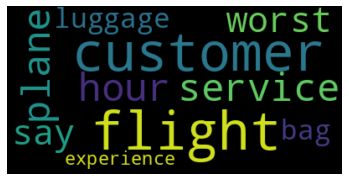

In [68]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

cloud = WordCloud().generate(topics[0])
plt.imshow(cloud, interpolation ="bilinear")
plt.axis("off");